# Calibrating the velocity field against observations 

In [ ]:
# Copyright (C) 2024 Richard Stiskalek
# This program is free software; you can redistribute it and/or modify it
# under the terms of the GNU General Public License as published by the
# Free Software Foundation; either version 3 of the License, or (at your
# option) any later version.
#
# This program is distributed in the hope that it will be useful, but
# WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General
# Public License for more details.
#
# You should have received a copy of the GNU General Public License along
# with this program; if not, write to the Free Software Foundation, Inc.,
# 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
import numpy as np
import matplotlib.pyplot as plt
import jax
from numpyro.infer import MCMC, NUTS, init_to_median
import corner
from getdist import plots
from scipy.stats import multivariate_normal

import csiborgtools

from flow_calibration import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)

## LOS density & radial velocity plots 

In [37]:
fpath = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation.hdf5"

loader_carrick = csiborgtools.flow.DataLoader("Carrick2015", 0, "LOSS", fpath, paths, ksmooth=0, )
loaders_csiborg2X = [csiborgtools.flow.DataLoader("csiborg2X", i, "LOSS", fpath, paths, ksmooth=1, verbose=False) for i in range(20)]
loaders_csiborg2 = [csiborgtools.flow.DataLoader("csiborg2_main", i, "LOSS", fpath, paths, ksmooth=1, verbose=False) for i in range(20)]

2024-06-21 17:15:50.033499:   reading the catalogue,
2024-06-21 17:15:50.046835:   reading the interpolated field,
2024-06-21 17:15:50.056588:   calculating the radial velocity.


/mnt/users/rstiskalek/csiborgtools/csiborgtools/flow/flow_model.py:92: UserWarning: The number of radial steps is even. Skipping the first step at 0.0 because Simpson's rule requires an odd number of steps.
  warn(f"The number of radial steps is even. Skipping the first "


In [ ]:
ks = [i for i in range(50)]

for k in ks:
    fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
    fig.subplots_adjust(wspace=0)
    cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # CSiBORG2
    x = loaders_csiborg2X[0].rdist
    y = np.asarray([loaders_csiborg2[i].los_density[k, :] for i in range(len(loaders_csiborg2X))])
    ylow, ymed, yhigh = np.percentile(y, [16, 50, 84], axis=0)
    axs[0].fill_between(x, ylow, yhigh, color=cols[0], alpha=0.25)
    axs[0].plot(x, ymed, color=cols[0], label="CSiBORG2")

    y = np.asarray([loaders_csiborg2[i].los_radial_velocity[k, :] for i in range(len(loaders_csiborg2X))])
    ylow, ymed, yhigh = np.percentile(y, [16, 50, 84], axis=0)
    axs[1].fill_between(x, ylow, yhigh, color=cols[0], alpha=0.25)
    axs[1].plot(x, ymed, color=cols[0], label="CSiBORG2")

    # CSiBORG2X
    x = loaders_csiborg2X[0].rdist
    y = np.asarray([loaders_csiborg2X[i].los_density[k, :] for i in range(len(loaders_csiborg2X))])
    ylow, ymed, yhigh = np.percentile(y, [16, 50, 84], axis=0)
    axs[0].fill_between(x, ylow, yhigh, color=cols[1], alpha=0.25)
    axs[0].plot(x, ymed, color=cols[1], label="CSiBORG2X")

    y = np.asarray([loaders_csiborg2X[i].los_radial_velocity[k, :] for i in range(len(loaders_csiborg2X))])
    ylow, ymed, yhigh = np.percentile(y, [16, 50, 84], axis=0)
    axs[1].fill_between(x, ylow, yhigh, color=cols[1], alpha=0.25)
    axs[1].plot(x, ymed, color=cols[1], label="CSiBORG2X")

    # Plot Carrick+2015
    axs[0].plot(loader_carrick.rdist, loader_carrick.los_density[k, :], color="red", label="Carrick+2015")
    axs[1].plot(loader_carrick.rdist, loader_carrick.los_radial_velocity[k, :] * 0.43, color="red")


    axs[1].set_xlabel(r"$r ~ [\mathrm{Mpc} / h]$")
    axs[0].set_ylabel(r"$\rho_{\rm LOS} / \langle \rho_{\rm matter} \rangle$")
    axs[1].set_ylabel(r"$v_{\rm LOS} ~ [\mathrm{km/s}]$")
    axs[0].set_yscale("log")

    axs[0].legend(loc="upper right")
    axs[0].set_xlim(0, 200)

    fig.tight_layout(w_pad=0, h_pad=0)
    fig.savefig(f"../../plots/LOSS_los_{k}.png", dpi=500, bbox_inches="tight")

    fig.show()

## Test running a model

In [91]:
fpath_data = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation.hdf5"
# fpath_data = "/mnt/extraspace/rstiskalek/catalogs/A2.h5"
# fpath_data = "/mnt/extraspace/rstiskalek/catalogs/PV_mock_CB2_17417_large.hdf5"

simname = "Carrick2015"
catalogue = "2MTF"
loader = csiborgtools.flow.DataLoader(simname, 0, catalogue, fpath_data, paths, ksmooth=0)
get_model_kwargs = {"zcmb_max": 0.05}

2024-06-21 18:08:51.114971:   reading the catalogue,
2024-06-21 18:08:51.122661:   reading the interpolated field,
2024-06-21 18:08:51.182633:   calculating the radial velocity.


/mnt/users/rstiskalek/csiborgtools/csiborgtools/flow/flow_model.py:91: UserWarning: The number of radial steps is even. Skipping the first step at 0.0 because Simpson's rule requires an odd number of steps.
  warn(f"The number of radial steps is even. Skipping the first "


#### Running HMC

In [104]:
model = csiborgtools.flow.get_model(loader, **get_model_kwargs)
model_kwargs = {"sample_alpha": True, "sample_beta": True}

Selected 1248/1248 galaxies.


In [105]:
kernel = NUTS(model, init_strategy=init_to_median(num_samples=100))
mcmc = MCMC(kernel, num_warmup=250, num_samples=500)

rng_key = jax.random.PRNGKey(5)
mcmc.run(rng_key, **model_kwargs)
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████| 750/750 [03:34<00:00,  3.50it/s, 7 steps of size 5.63e-01. acc. prob=0.88] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
          Vext_x   -107.14     16.03   -107.20   -132.71    -81.92    985.54      1.00
          Vext_y   -103.76     18.57   -103.98   -134.73    -73.43    686.42      1.01
          Vext_z   -114.33     17.71   -113.60   -143.50    -86.52    489.79      1.00
               a    -22.28      0.02    -22.28    -22.31    -22.25    647.90      1.00
           alpha      1.53      0.08      1.53      1.39      1.66    872.66      1.00
               b     -6.28      0.09     -6.27     -6.41     -6.12    799.07      1.00
            beta      0.40      0.03      0.41      0.36      0.44    718.68      1.00
  e_mu_intrinsic      0.41      0.01      0.41      0.39      0.42    594.15      1.00
         sigma_v    115.92     11.15    115.45     98.05    133.76    732.54      1.00

Number of divergences: 0


In [88]:
ndata = 1248
from jax import numpy as jnp
from jax import devices

ndevices = 2
indxs = jnp.arange(ndata).reshape(ndevices, -1)

In [90]:
indxs

Array([[   0,    1,    2, ...,  621,  622,  623],
       [ 624,  625,  626, ..., 1245, 1246, 1247]], dtype=int32)

In [79]:
Vmag = np.sqrt(samples["Vext_x"]**2 + samples["Vext_y"]**2 + samples["Vext_z"]**2)

V = np.vstack([samples["Vext_x"], samples["Vext_y"], samples["Vext_z"]]).T
V = csiborgtools.cartesian_to_radec(V)

l, b = csiborgtools.flow.radec_to_galactic(V[:, 1], V[:, 2])

print(f"|V|  = {np.mean(Vmag)} +- {np.std(Vmag)}")
print(f"l    = {np.mean(l)} +- {np.std(l)}")
print(f"b    = {np.mean(b)} +- {np.std(b)}")
if "beta" in samples:
    print(f"beta = {np.mean(samples['beta'])} +- {np.std(samples['beta'])}")

|V|  = 189.18643188476562 +- 18.434009552001953
l    = 328.73439952474195 +- 6.045875008151092
b    = 19.147533871849525 +- 5.45638871095807
beta = 0.40421125292778015 +- 0.02472345344722271


In [81]:
jax.devices()

[CpuDevice(id=0)]

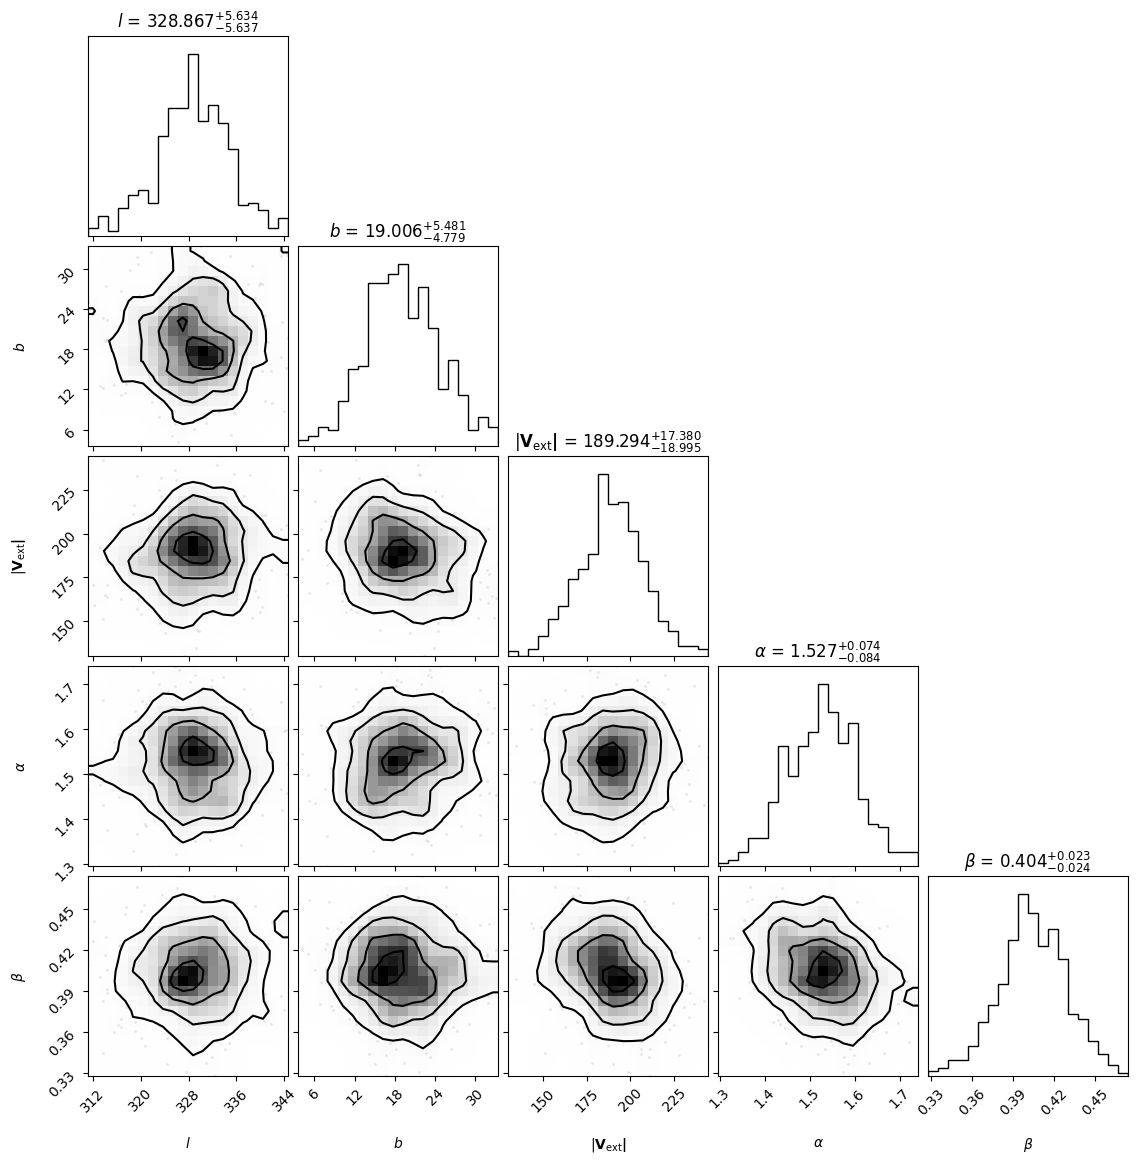

In [80]:
data = [l, b, Vmag]
labels = [r"$l$", r"$b$", r"$|\bf{V}_{\rm ext}|$"]
if "alpha" in samples:
    data.append(samples["alpha"])
    labels.append(r"$\alpha$")

if "beta" in samples:
    data.append(samples["beta"])
    labels.append(r"$\beta$")

if "h" in samples:
    data.append(samples["h"])
    labels.append(r"$h$")

data = np.vstack(data).T
fig = corner.corner(data, labels=labels, show_titles=True, title_fmt=".3f", title_kwargs={"fontsize": 12}, smooth=1)
fig.savefig(f"../../plots/mock_{simname}_{catalogue}.png", dpi=500, bbox_inches="tight")

## Vizualize the results

In [ ]:
data, names, gof = read_samples("Pantheon+_groups", "Carrick2015", 0)

fig = corner.corner(data, labels=names_to_latex(names, True), show_titles=True,
                    title_fmt=".3f", title_kwargs={"fontsize": 12}, smooth=1)

### $\texttt{LOSS}$ comparison

In [ ]:
LOSS_Carrick_0 = read_samples("LOSS", "Carrick2015", 0, return_MCsamples=True)
LOSS_Carrick_1 = read_samples("LOSS", "Carrick2015", 1, return_MCsamples=True)

LOSS_CB1_0 = read_samples("LOSS", "csiborg1", 0, return_MCsamples=True)
LOSS_CB1_1 = read_samples("LOSS", "csiborg1", 1, return_MCsamples=True)

LOSS_CB2_0 = read_samples("LOSS", "csiborg2_main", 0, return_MCsamples=True)
LOSS_CB2_1 = read_samples("LOSS", "csiborg2_main", 1, return_MCsamples=True)

In [ ]:
X = [
     LOSS_Carrick_0,
     # LOSS_Carrick_1,
     # LOSS_CB1_0,
     LOSS_CB1_1,
     LOSS_CB2_0,
     LOSS_CB2_1,
     ]

# params = ["l", "b", "Vmag", "beta"]
params = None

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right', )
g.export(f"../plots/LOSS_comparison.png", dpi=500,)


### $\texttt{Foundation}$ comparison

In [ ]:
FOUNDATION_Carrick_0 = read_samples("Foundation", "Carrick2015", 0, return_MCsamples=True)
FOUNDATION_Carrick_1 = read_samples("Foundation", "Carrick2015", 1, return_MCsamples=True)

FOUNDATION_CB1_0 = read_samples("Foundation", "csiborg1", 0, return_MCsamples=True)
FOUNDATION_CB1_1 = read_samples("Foundation", "csiborg1", 1, return_MCsamples=True)

FOUNDATION_CB2_0 = read_samples("Foundation", "csiborg2_main", 0, return_MCsamples=True)
FOUNDATION_CB2_1 = read_samples("Foundation", "csiborg2_main", 1, return_MCsamples=True)

In [ ]:
X = [
    FOUNDATION_Carrick_0,
    # FOUNDATION_Carrick_1,
    # FOUNDATION_CB1_0,
    FOUNDATION_CB1_1,
    FOUNDATION_CB2_0,
    FOUNDATION_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/FOUNDATION_comparison.png", dpi=500,)

### $\texttt{Pantheon+}$ comparison

In [ ]:
PANTHEONP_Carrick_0 = read_samples("Pantheon+", "Carrick2015", 0, return_MCsamples=True)
PANTHEONP_Carrick_1 = read_samples("Pantheon+", "Carrick2015", 1, return_MCsamples=True)

# PANTHEONP_CB1_0 = read_samples("Pantheon+", "csiborg1", 0, return_MCsamples=True)
# PANTHEONP_CB1_1 = read_samples("Pantheon+", "csiborg1", 1, return_MCsamples=True)

PANTHEONP_CB2_0 = read_samples("Pantheon+", "csiborg2_main", 0, return_MCsamples=True)
PANTHEONP_CB2_1 = read_samples("Pantheon+", "csiborg2_main", 1, return_MCsamples=True)


In [ ]:
X = [
    PANTHEONP_Carrick_0,
    # PANTHEONP_Carrick_1,
    # PANTHEONP_CB1_0,
    # PANTHEONP_CB1_1,
    PANTHEONP_CB2_0,
    PANTHEONP_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
# g.export(f"../plots/PANTHEONP_comparison.png", dpi=500,)

### $\texttt{Pantheon+}$ groups

In [ ]:
LG = -1

PANTHEONP_Carrick = read_samples("Pantheon+", "Carrick2015", 0, return_MCsamples=True, subtract_LG_velocity=LG, )
PANTHEONP_Carrick_Groups = read_samples("Pantheon+_groups", "Carrick2015", 0, return_MCsamples=True, subtract_LG_velocity=LG)
PANTHEONP_Carrick_Groups_zSN = read_samples("Pantheon+_groups_zSN", "Carrick2015", 0, return_MCsamples=True, subtract_LG_velocity=LG)
PANTHEONP_Carrick_zSN = read_samples("Pantheon+_zSN", "Carrick2015", 0, return_MCsamples=True, subtract_LG_velocity=LG)

# ksmooth = 1
# PANTHEONP_CB2 = read_samples("Pantheon+", "csiborg2_main", ksmooth, return_MCsamples=True, subtract_LG_velocity=LG)
# PANTHEONP_CB2_Groups = read_samples("Pantheon+_groups", "csiborg2_main", ksmooth, return_MCsamples=True, subtract_LG_velocity=LG)
# PANTHEONP_CB2_Groups_zSN = read_samples("Pantheon+_groups_zSN", "csiborg2_main", ksmooth, return_MCsamples=True, subtract_LG_velocity=LG)




In [ ]:
params = ["Vmag", "l", "b"]
CMB = MCSamples(samples=multivariate_normal([627, 276, 30], [22, 3, 3]).rvs(size=20000),
                names=params, labels=names_to_latex(params, True), label="CMB")


X = [
    PANTHEONP_Carrick,
    # PANTHEONP_Carrick_Groups,
    # PANTHEONP_Carrick_Groups_zSN,
    PANTHEONP_Carrick_zSN,
    # PANTHEONP_CB2,
    # PANTHEONP_CB2_Groups,
    # PANTHEONP_CB2_Groups_zSN,
    # CMB,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../../plots/PANTHEON_GROUPS_Carrick_comparison_LG.png", dpi=500,)

### $\texttt{2MTF}$ comparison

In [ ]:
TWOMTF_Carrick_0 = read_samples("2MTF", "Carrick2015", 0, return_MCsamples=True)
TWOMTF_Carrick_1 = read_samples("2MTF", "Carrick2015", 1, return_MCsamples=True)

TWOMTF_CB1_0 = read_samples("2MTF", "csiborg1", 0, return_MCsamples=True)
TWOMTF_CB1_1 = read_samples("2MTF", "csiborg1", 1, return_MCsamples=True)

TWOMTF_CB2_0 = read_samples("2MTF", "csiborg2_main", 0, return_MCsamples=True)
TWOMTF_CB2_1 = read_samples("2MTF", "csiborg2_main", 1, return_MCsamples=True)


In [ ]:
X = [
    TWOMTF_Carrick_0,
    # TWOMTF_Carrick_1,
    # TWOMTF_CB1_0,
    TWOMTF_CB1_1,
    TWOMTF_CB2_0,
    TWOMTF_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/2MTF_comparison.png", dpi=500,)

### $\texttt{SFI++ galaxies}$ comparison

In [ ]:
SFIGAL_Carrick_0 = read_samples("SFI_gals", "Carrick2015", 0, return_MCsamples=True)
SFIGAL_Carrick_1 = read_samples("SFI_gals", "Carrick2015", 1, return_MCsamples=True)

# SFIGAL_CB1_0 = read_samples("SFI_gals", "csiborg1", 0, return_MCsamples=True)
# SFIGAL_CB1_1 = read_samples("SFI_gals", "csiborg1", 1, return_MCsamples=True)

SFIGAL_CB2_0 = read_samples("SFI_gals", "csiborg2_main", 0, return_MCsamples=True)
SFIGAL_CB2_1 = read_samples("SFI_gals", "csiborg2_main", 1, return_MCsamples=True)

In [ ]:
X = [
    SFIGAL_Carrick_0,
    # SFIGAL_Carrick_1,
    # SFIGAL_CB1_0,
    # SFIGAL_CB1_1,
    # SFIGAL_CB2_0,
    SFIGAL_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/SFI_gals_comparison.png", dpi=500,)

### $\texttt{SFI++ groups}$ comparison

In [ ]:
SFIGROUP_Carrick_0 = read_samples("SFI_groups", "Carrick2015", 0, return_MCsamples=True)
SFIGROUP_Carrick_1 = read_samples("SFI_groups", "Carrick2015", 1, return_MCsamples=True)

SFIGROUP_CB2_0 = read_samples("SFI_groups", "csiborg2_main", 0, return_MCsamples=True)
SFIGROUP_CB2_1 = read_samples("SFI_groups", "csiborg2_main", 1, return_MCsamples=True)

In [ ]:
X = [
    SFIGROUP_Carrick_0,
    SFIGAL_Carrick_0,
    # SFIGROUP_Carrick_1,
    # SFIGROUP_CB2_0,
    # SFIGROUP_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/SFI_gals_vs_groups_comparison.png", dpi=500,)

### SN to TF comparison

In [ ]:
LG = 0

# PANTHEONP_Carrick = read_samples("Pantheon+", "Carrick2015", 0, return_MCsamples=True, subtract_LG_velocity=LG, )
# PANTHEONP_Groups_Carrick = read_samples("Pantheon+_groups", "Carrick2015", 0, return_MCsamples=True, subtract_LG_velocity=LG, )
# TWOMTF_Carrick = read_samples("2MTF", "Carrick2015", 0, return_MCsamples=True, subtract_LG_velocity=LG)
# SFIGAL_Carrick = read_samples("SFI_gals", "Carrick2015", 0, return_MCsamples=True, subtract_LG_velocity=LG)

k = 1
PANTHEONP_CB2 = read_samples("Pantheon+", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG, )
PANTHEONP_Groups_CB2 = read_samples("Pantheon+_groups", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG, )
TWOMTF_CB2 = read_samples("2MTF", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)
SFIGAL_CB2 = read_samples("SFI_gals", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)

In [ ]:

params = ["Vmag", "l", "b"]
CMB = MCSamples(samples=multivariate_normal([627, 276, 30], [22, 3, 3]).rvs(size=20000),
                names=params, labels=names_to_latex(params, True), label="CMB")


X = [
    # PANTHEONP_Carrick,
    # PANTHEONP_Groups_Carrick,
    # TWOMTF_Carrick,
    # SFIGAL_Carrick,
    PANTHEONP_CB2,
    PANTHEONP_Groups_CB2,
    TWOMTF_CB2,
    SFIGAL_CB2,
    CMB,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
# g.export(f"../../plots/SN_TF_CB2_consistency.png", dpi=500,)

### Mock $\texttt{CB2}$ comparison

In [ ]:
SMALLMOCK_CB2_0 = read_samples("CB2_small", "csiborg2_main", 0, return_MCsamples=True)
SMALLMOCK_CB2_1 = read_samples("CB2_small", "csiborg2_main", 1, return_MCsamples=True)

LARGEMOCK_CB2_0 = read_samples("CB2_large", "csiborg2_main", 0, return_MCsamples=True)
LARGEMOCK_CB2_1 = read_samples("CB2_large", "csiborg2_main", 1, return_MCsamples=True)

In [ ]:
X = [
    # SMALLMOCK_CB2_0,
    # SMALLMOCK_CB2_1,
    LARGEMOCK_CB2_0,
    LARGEMOCK_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/CB2_mocks_large.png", dpi=500,)

## External flow consistency

#### Carrick2015

In [ ]:
X = [
    # LOSS_Carrick_0,
    # FOUNDATION_Carrick_0,
    PANTHEONP_Carrick_0,
    TWOMTF_Carrick_0,
    SFIGAL_Carrick_0,
    ]

params = ["Vmag", "l", "b", "beta"]
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right',)
g.export(f"../plots/Carrick2015_external_flow.png", dpi=500,)

#### CSiBORG1

In [ ]:
X = [
    # LOSS_CB1_1,
    # FOUNDATION_CB1_1,
    PANTHEONP_CB1_1,
    TWOMTF_CB1_1,
    # SFIGAL_CB1_1,
    ]

params = ["Vmag", "l", "b", "beta"]
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right',)
g.export(f"../plots/CB1_external_flow.png", dpi=500,)

#### CSiBORG2

In [ ]:
X = [
    # LOSS_CB2_1,
    # FOUNDATION_CB2_1,
    PANTHEONP_CB2_1,
    TWOMTF_CB2_1,
    SFIGAL_CB2_1,
    ]

params = ["Vmag", "l", "b", "beta"]
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right',)
g.export(f"../plots/CB2_external_flow.png", dpi=500,)

In [ ]:
k = 1
LG = 0

# Carrick
# LOSS_Carrick_LG = read_samples("LOSS", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)
# FOUNDATION_Carrick_LG = read_samples("Foundation", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)
# PANTHEON_Carrick_LG = read_samples("Pantheon+", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)
# TWOMTF_Carrick_LG = read_samples("2MTF", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)
SFIGAL_Carrick_LG = read_samples("SFI_gals", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)
SFIGROUPS_Carrick_LG = read_samples("SFI_groups", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)


# # CSiBORG2
# LOSS_CB2_LG = read_samples("LOSS", "csiborg2_main", k, return_MCsamples=True,subtract_LG_velocity=LG)
# FOUNDATION_CB2_LG = read_samples("Foundation", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)
# PANTHEON_CB2_LG = read_samples("Pantheon+", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)
# TWOMTF_CB2_LG = read_samples("2MTF", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)
SFIGAL_CB2_LG = read_samples("SFI_gals", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)
SFIGROUP_CB2_LG = read_samples("SFI_groups", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)

# # CSiBORG1
# LOSS_CB1_LG = read_samples("LOSS", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)
# FOUNDATION_CB1_LG = read_samples("Foundation", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)
# PANTHEON_CB1_LG = read_samples("Pantheon+", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)
# TWOMTF_CB1_LG = read_samples("2MTF", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)
# SFIGAL_CB1_LG = read_samples("SFI_gals", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)

In [ ]:
params = ["Vmag", "l", "b"]
CMB = MCSamples(samples=multivariate_normal([627, 276, 30], [22, 3, 3]).rvs(size=20000),
                names=params, labels=names_to_latex(params, True), label="CMB")

X = [
    # LOSS_Carrick_LG,
    # FOUNDATION_Carrick_LG,
    # PANTHEON_Carrick_LG,
    # TWOMTF_Carrick_LG,
    # SFIGAL_Carrick_LG,
    # SFIGROUPS_Carrick_LG,
    # LOSS_CB1_LG,
    # FOUNDATION_CB1_LG,
    # PANTHEON_CB1_LG,
    # TWOMTF_CB1_LG,
    # SFIGAL_CB1_LG,
    # LOSS_CB2_LG,
    # FOUNDATION_CB2_LG,
    # PANTHEON_CB2_LG,
    # TWOMTF_CB2_LG,
    SFIGAL_CB2_LG,
    SFIGROUP_CB2_LG,
    CMB,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right', )
# g.export(f"../plots/ALL_dipole.png", dpi=500,)